In [1]:
# ============================================
# 0. INSTALLS & IMPORTS
# ============================================
!pip install -q "transformers>=4.46.0" "mistral_common[audio]>=1.8.6" "accelerate>=0.34.0" pandas einops plotly

from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import re

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
from transformers import VoxtralForConditionalGeneration, AutoProcessor

import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

import plotly.express as px
import plotly.graph_objects as go

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.3 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# ============================================
# 1. BUILD DATAFRAME (ENGLISH ONLY)
# ============================================
ROOT_DIR = "/content/drive/MyDrive/adsp/downloads/esd/Emotion Speech Dataset"

# 0011–0020 are English speakers
EN_SPEAKERS = [f"{i:04d}" for i in range(11, 21)]

rows = []
for spk in EN_SPEAKERS:
    txt_path = os.path.join(ROOT_DIR, spk, f"{spk}.txt")
    if not os.path.exists(txt_path):
        print(f"[WARN] transcript missing: {txt_path}")
        continue

    with open(txt_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            utt_id = parts[0]      # e.g. 0011_000001
            emo = parts[-1]        # Angry / Happy / Neutral / Sad / Surprise
            sent = " ".join(parts[1:-1])

            wav_path = os.path.join(ROOT_DIR, spk, emo, f"{utt_id}.wav")
            if not os.path.exists(wav_path):
                cands = glob.glob(
                    os.path.join(ROOT_DIR, spk, "**", f"{utt_id}.wav"),
                    recursive=True
                )
                if not cands:
                    print(f"[MISS] audio for {utt_id}")
                    continue
                wav_path = cands[0]

            rows.append({
                "speaker": spk,
                "utt_id": utt_id,
                "audio_path": wav_path,
                "transcript": sent,
                "emotion": emo,
            })

df = pd.DataFrame(rows)
print("Total English utterances:", len(df))
display(df.head())

Total English utterances: 17500


,speaker,utt_id,audio_path,transcript,emotion
0,0011,0011_000001,/content/drive/MyDrive/adsp/downloads/esd/Emot...,"The nine the eggs, I keep.",Neutral
1,0011,0011_000002,/content/drive/MyDrive/adsp/downloads/esd/Emot...,"I did go, and made many prisoners.",Neutral
2,0011,0011_000003,/content/drive/MyDrive/adsp/downloads/esd/Emot...,That I owe my thanks to you.,Neutral
3,0011,0011_000004,/content/drive/MyDrive/adsp/downloads/esd/Emot...,They went up to the dark mass job had pointed ...,Neutral
4,0011,0011_000005,/content/drive/MyDrive/adsp/downloads/esd/Emot...,Clear than clear water!,Neutral


In [3]:
# ============================================
# 1b. OPTIONAL: STRATIFIED SUBSAMPLE FOR EVAL
# ============================================
USE_SUBSAMPLE = True     # set False if you want full dataset
N_PER_CLASS   = 500       # max samples per emotion (tune if needed)

print("\nFull dataset emotion counts:")
print(df["emotion"].value_counts())

if USE_SUBSAMPLE:
    def sample_per_class(g):
        return g.sample(
            n=min(len(g), N_PER_CLASS),
            random_state=42
        )

    df_sub = (
        df.groupby("emotion", group_keys=False)
          .apply(sample_per_class)
          .reset_index(drop=True)
    )

    print("\nUsing SUBSAMPLE for evaluation:")
    print("Subsample size:", len(df_sub))
    print(df_sub["emotion"].value_counts())
else:
    df_sub = df



Full dataset emotion counts:
emotion
Neutral     3500
Angry       3500
Happy       3500
Sad         3500
Surprise    3500
Name: count, dtype: int64

Using SUBSAMPLE for evaluation:
Subsample size: 2500
emotion
Angry       500
Happy       500
Neutral     500
Sad         500
Surprise    500
Name: count, dtype: int64


/tmp/ipython-input-2286863276.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_per_class)


In [4]:
# ============================================
# 2. LOAD VOXTRAL-MINI-3B (single box)
# ============================================
import os
import torch
from transformers import AutoProcessor, VoxtralForConditionalGeneration

REPO_ID = "mistralai/Voxtral-Mini-3B-2507"

# ---- OPTIONAL: put your HF token here once (recommended) ----
# HF_TOKEN = "hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
HF_TOKEN = os.environ.get("HF_TOKEN", None)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---- load processor ----
processor = AutoProcessor.from_pretrained(
    REPO_ID,
    token=HF_TOKEN,
    trust_remote_code=True,
)

# ---- load model (fp16 on GPU, auto device map) ----
model = VoxtralForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else {"": "cpu"},
    token=HF_TOKEN,
    trust_remote_code=True,
)

model.eval()
print("Model loaded.")

# your label list (change if you need 4-class)
LABELS = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tekken.json:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.38G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/108 [00:00<?, ?B/s]

Model loaded.


In [5]:
# ============================================
# 3. LABEL NORMALIZATION
# ============================================
def normalize_label(text: str) -> str:
    text = text.lower()
    # direct substring match
    for lab in LABELS:
        if lab.lower() in text:
            return lab
    # word-level match
    words = re.findall(r"[a-zA-Z]+", text)
    for w in words:
        for lab in LABELS:
            if w == lab.lower():
                return lab
    return "Unknown"

In [6]:
# ============================================
# 4. SINGLE-SAMPLE PREDICTOR (DEBUGGING)
# ============================================
def voxtral_predict(
    audio_path: str,
    transcript: str = "",
    use_text: bool = False,
    max_new_tokens: int = 3,
) -> str:
    """
    Zero-shot emotion prediction for a single sample.
    use_text = False -> audio only
    use_text = True  -> audio + transcript
    """
    file_url = "file://" + os.path.abspath(audio_path)

    content = [
        {
            "type": "audio_url",
            "audio_url": file_url,
        }
    ]

    if use_text and transcript.strip():
        content.append({"type": "text", "text": f"Transcript: {transcript}"})

    content.append({
        "type": "text",
        "text": (
            "Classify the speaker's emotion. "
            "Answer with ONLY one word from [Angry, Happy, Neutral, Sad, Surprise]."
        ),
    })

    conversation = [{"role": "user", "content": content}]

    inputs = processor.apply_chat_template(
        conversation,
        tokenize=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    new_tokens = outputs[:, inputs["input_ids"].shape[1]:]
    decoded = processor.batch_decode(new_tokens, skip_special_tokens=True)[0]
    return normalize_label(decoded)

# Quick sanity check on one row (OPTIONAL)
row = df_sub.iloc[0]
print("\n=== Sanity check on one sample (from subsample) ===")
print("Audio:", row.audio_path)
print("Transcript:", row.transcript)
print("Gold:", row.emotion)
print("Pred (audio only):", voxtral_predict(row.audio_path, use_text=False))
print("Pred (audio + text):", voxtral_predict(row.audio_path, row.transcript, use_text=True))



=== Sanity check on one sample (from subsample) ===
Audio: /content/drive/MyDrive/adsp/downloads/esd/Emotion Speech Dataset/0015/Angry/0015_000601.wav
Transcript: The ladybug told them proudly.
Gold: Angry
Pred (audio only): Happy
Pred (audio + text): Happy


In [7]:
# ============================================
# 5. BATCHED PREDICTION
# ============================================
def build_conversation_for_row(audio_path: str, transcript: str, use_text: bool) -> dict:
    """Create one-chat turn for a given row, matching the single-sample logic."""
    file_url = "file://" + os.path.abspath(audio_path)

    content = [
        {
            "type": "audio_url",
            "audio_url": file_url,
        }
    ]

    if use_text and transcript.strip():
        content.append({"type": "text", "text": f"Transcript: {transcript}"})

    content.append({
        "type": "text",
        "text": (
            "Classify the speaker's emotion. "
            "Answer with ONLY one word from [Angry, Happy, Neutral, Sad, Surprise]."
        ),
    })

    return {"role": "user", "content": content}


def voxtral_predict_batch(
    df_batch: pd.DataFrame,
    use_text: bool,
    max_new_tokens: int = 3,
) -> list[str]:
    """
    Batched zero-shot prediction for a slice of the dataframe.
    Returns list of labels (same order as df_batch).
    """
    conversations = []
    for _, row in df_batch.iterrows():
        conv = [build_conversation_for_row(
            audio_path=row["audio_path"],
            transcript=row["transcript"],
            use_text=use_text,
        )]
        conversations.append(conv)

    inputs = processor.apply_chat_template(
        conversations,
        tokenize=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    input_ids = inputs["input_ids"]
    new_tokens = outputs[:, input_ids.shape[1]:]
    decoded_list = processor.batch_decode(new_tokens, skip_special_tokens=True)

    labels = [normalize_label(text) for text in decoded_list]
    return labels


def run_batched_predictions(df_in: pd.DataFrame, batch_size: int = 4) -> pd.DataFrame:
    """
    Full fast prediction over df_in using batched Voxtral calls.
    Adds:
        pred_audio : audio-only prediction
        pred_both  : audio+transcript prediction
    """
    df_eval = df_in.reset_index(drop=True).copy()

    all_pa = []
    all_pb = []

    n = len(df_eval)
    n_batches = (n + batch_size - 1) // batch_size

    for start in tqdm(range(0, n, batch_size), total=n_batches):
        end = min(start + batch_size, n)
        batch = df_eval.iloc[start:end]

        # Audio only
        batch_pa = voxtral_predict_batch(batch, use_text=False)

        # Audio + transcript
        batch_pb = voxtral_predict_batch(batch, use_text=True)

        all_pa.extend(batch_pa)
        all_pb.extend(batch_pb)

    df_eval["pred_audio"] = all_pa
    df_eval["pred_both"] = all_pb
    return df_eval


In [8]:
# ============================================
# 6. RUN FAST PREDICTIONS (ON SUBSAMPLE)
# ============================================
# Tune batch_size based on GPU memory.
df_eval = run_batched_predictions(df_sub, batch_size=8)
display(df_eval.head())


  0%|          | 0/313 [00:00<?, ?it/s]

,speaker,utt_id,audio_path,transcript,emotion,pred_audio,pred_both
0,0015,0015_000601,/content/drive/MyDrive/adsp/downloads/esd/Emot...,The ladybug told them proudly.,Angry,Happy,Happy
1,0018,0018_000357,/content/drive/MyDrive/adsp/downloads/esd/Emot...,I'm as bad as I can be.,Angry,Neutral,Angry
2,0017,0017_000483,/content/drive/MyDrive/adsp/downloads/esd/Emot...,I smell the breath of an English.,Angry,Neutral,Neutral
3,0016,0016_000546,/content/drive/MyDrive/adsp/downloads/esd/Emot...,Clear are your eyes and bright your breath!,Angry,Neutral,Neutral
4,0011,0011_000660,/content/drive/MyDrive/adsp/downloads/esd/Emot...,Why it is just like the round egg which sounds...,Angry,Neutral,Neutral


In [9]:
# ================================
# 7. METRICS & COMPARISON
# ================================
y_true = df_eval["emotion"].values
y_pa   = df_eval["pred_audio"].values
y_pb   = df_eval["pred_both"].values

print("Label set in ground truth:", sorted(set(y_true)))
print("Label set in audio preds :", sorted(set(y_pa)))
print("Label set in audiotext   :", sorted(set(y_pb)))

# --- make sure we have plain Python floats ---
acc_audio = float(accuracy_score(y_true, y_pa))
acc_both  = float(accuracy_score(y_true, y_pb))

f1m_audio = float(f1_score(y_true, y_pa, labels=LABELS, average="macro"))
f1m_both  = float(f1_score(y_true, y_pb, labels=LABELS, average="macro"))

print("\n=== Global metrics ===")
print(f"Accuracy (audio only) : {acc_audio:.3f}")
print(f"Accuracy (audio+text) : {acc_both:.3f}")
print(f"Macro-F1 (audio only) : {f1m_audio:.3f}")
print(f"Macro-F1 (audio+text) : {f1m_both:.3f}")


Label set in ground truth: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Label set in audio preds : ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Label set in audiotext   : ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

=== Global metrics ===
Accuracy (audio only) : 0.278
Accuracy (audio+text) : 0.250
Macro-F1 (audio only) : 0.248
Macro-F1 (audio+text) : 0.220


In [10]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import plotly.express as px

# ---- per-class classification reports (dict) ----
rep_audio = classification_report(
    y_true, y_pa, labels=LABELS, output_dict=True, zero_division=0
)
rep_both = classification_report(
    y_true, y_pb, labels=LABELS, output_dict=True, zero_division=0
)

# build DataFrames restricted to real classes
perclass_audio = (
    pd.DataFrame(rep_audio)
    .T.loc[LABELS, ["precision", "recall", "f1-score"]]
    .rename(columns=lambda c: f"{c}_audio")
)
perclass_both = (
    pd.DataFrame(rep_both)
    .T.loc[LABELS, ["precision", "recall", "f1-score"]]
    .rename(columns=lambda c: f"{c}_both")
)

perclass = perclass_audio.join(perclass_both)
perclass["ΔF1"] = perclass["f1-score_both"] - perclass["f1-score_audio"]
perclass["ΔRecall"] = perclass["recall_both"] - perclass["recall_audio"]

display(perclass.round(3))


,precision_audio,recall_audio,f1-score_audio,precision_both,recall_both,f1-score_both,ΔF1,ΔRecall
Angry,0.274,0.124,0.171,0.240,0.094,0.135,-0.036,-0.030
Happy,0.217,0.092,0.129,0.213,0.120,0.153,0.024,0.028
Neutral,0.231,0.630,0.338,0.219,0.630,0.325,-0.013,0.000
Sad,0.261,0.124,0.168,0.224,0.094,0.132,-0.036,-0.030
Surprise,0.452,0.418,0.435,0.415,0.312,0.356,-0.078,-0.106


In [11]:
# long format for plotly
f1_long = (
    perclass.reset_index()
    .melt(id_vars="index",
          value_vars=["f1-score_audio", "f1-score_both"],
          var_name="system", value_name="F1")
)
f1_long["system"] = f1_long["system"].map(
    {"f1-score_audio": "Audio only", "f1-score_both": "Audio + text"}
)

fig_f1 = px.bar(
    f1_long,
    x="index",
    y="F1",
    color="system",
    barmode="group",
    title="F1 per emotion: audio vs audio+text",
    labels={"index": "Emotion"}
)
fig_f1.update_layout(template="plotly_white")
fig_f1.show()

# ΔF1 line plot
fig_df1 = px.scatter(
    perclass.reset_index(),
    x="index",
    y="ΔF1",
    text="index",
    title="ΔF1 (audio+text − audio) per emotion",
    labels={"index": "Emotion", "ΔF1": "Delta F1"}
)
fig_df1.add_hline(y=0, line_dash="dash")
fig_df1.update_traces(textposition="top center")
fig_df1.update_layout(template="plotly_white")
fig_df1.show()


In [12]:
# helper: per-speaker accuracy for a given prediction column
def speaker_accuracy(df, pred_col):
    return (
        df.assign(correct=lambda d: d["emotion"] == d[pred_col])
          .groupby("speaker")["correct"]
          .mean()
          .rename(f"acc_{pred_col}")
    )

acc_sp_audio = speaker_accuracy(df_eval, "pred_audio")
acc_sp_both  = speaker_accuracy(df_eval, "pred_both")

sp_acc = pd.concat([acc_sp_audio, acc_sp_both], axis=1)
sp_acc["Δacc"] = sp_acc["acc_pred_both"] - sp_acc["acc_pred_audio"]
display(sp_acc.sort_values("Δacc").round(3))


,acc_pred_audio,acc_pred_both,Δacc
speaker,,,
0017,0.281,0.222,-0.059
0015,0.302,0.247,-0.055
0013,0.302,0.271,-0.031
0019,0.291,0.261,-0.030
0016,0.271,0.242,-0.029
0018,0.307,0.280,-0.027
0012,0.243,0.220,-0.024
0011,0.266,0.249,-0.016
0020,0.269,0.253,-0.016


In [13]:
fig_sp = px.bar(
    sp_acc.reset_index(),
    x="speaker",
    y="Δacc",
    title="ΔAccuracy per speaker (audio+text − audio)",
    labels={"Δacc": "Delta accuracy"},
)
fig_sp.add_hline(y=0, line_dash="dash")
fig_sp.update_layout(template="plotly_white")
fig_sp.show()


In [14]:
# cm_audio / cm_both already computed: rows=true, cols=pred
cm_audio = confusion_matrix(y_true, y_pa, labels=LABELS)
cm_both  = confusion_matrix(y_true, y_pb, labels=LABELS)

def dominant_confusions(cm, labels):
    rows = []
    for i, true_lab in enumerate(labels):
        row = cm[i].copy()
        row[i] = 0  # ignore correct predictions
        if row.sum() == 0:
            rows.append({"true": true_lab, "confused_with": None, "count": 0})
        else:
            j = row.argmax()
            rows.append({
                "true": true_lab,
                "confused_with": labels[j],
                "count": int(row[j]),
            })
    return pd.DataFrame(rows)

dom_audio = dominant_confusions(cm_audio, LABELS).rename(
    columns={"confused_with": "confused_with_audio",
             "count": "count_audio"}
)
dom_both = dominant_confusions(cm_both, LABELS).rename(
    columns={"confused_with": "confused_with_both",
             "count": "count_both"}
)

dom = dom_audio.merge(dom_both, on="true")
display(dom)


,true,confused_with_audio,count_audio,confused_with_both,count_both
0,Angry,Neutral,265,Neutral,291
1,Happy,Neutral,292,Neutral,301
2,Neutral,Sad,54,Happy,58
3,Sad,Neutral,304,Neutral,313
4,Surprise,Neutral,186,Neutral,216


In [15]:
fig_err = px.bar(
    dom.melt(id_vars="true",
             value_vars=["count_audio", "count_both"],
             var_name="system", value_name="count"),
    x="true",
    y="count",
    color="system",
    barmode="group",
    title="Most frequent misclassification count per emotion",
    labels={"true": "Emotion"}
)
fig_err.update_layout(template="plotly_white")
fig_err.show()


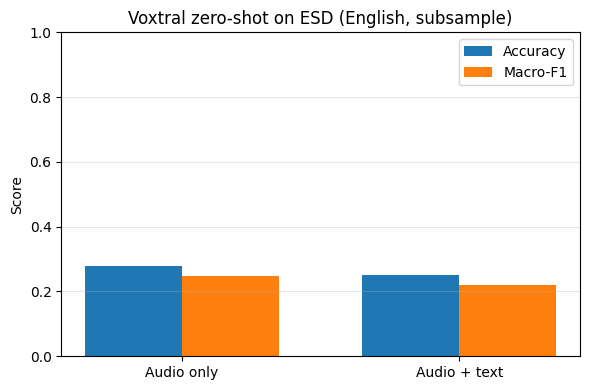

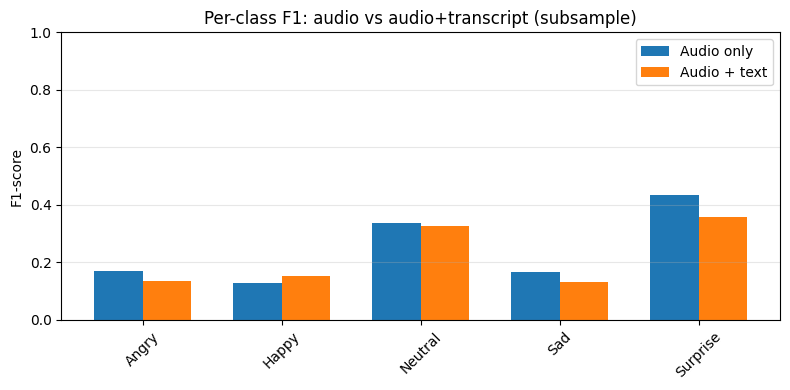

In [16]:
# ============================================
# 8. MATPLOTLIB PLOTS
# ============================================
systems = ["Audio only", "Audio + text"]
accs    = [acc_audio, acc_both]
f1s     = [f1m_audio, f1m_both]

x = np.arange(len(systems))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, f1s, width, label="Macro-F1")
plt.xticks(x, systems, rotation=0)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Voxtral zero-shot on ESD (English, subsample)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

_, _, f1_audio_per_class, _ = precision_recall_fscore_support(
    y_true, y_pa, labels=LABELS, average=None
)
_, _, f1_both_per_class, _ = precision_recall_fscore_support(
    y_true, y_pb, labels=LABELS, average=None
)

x = np.arange(len(LABELS))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, f1_audio_per_class, width, label="Audio only")
plt.bar(x + width/2, f1_both_per_class,  width, label="Audio + text")
plt.xticks(x, LABELS, rotation=45)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.title("Per-class F1: audio vs audio+transcript (subsample)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import plotly.express as px

# y_true, y_pa, y_pb, LABELS must already be defined above

# 4) CONFUSION MATRICES (HEATMAPS, PERCENTAGES)
cm_audio = confusion_matrix(y_true, y_pa, labels=LABELS)
cm_both  = confusion_matrix(y_true, y_pb, labels=LABELS)

cm_audio_pct = cm_audio.astype(float) / cm_audio.sum(axis=1, keepdims=True)
cm_both_pct  = cm_both.astype(float)  / cm_both.sum(axis=1, keepdims=True)

fig_cm_audio = px.imshow(
    cm_audio_pct,
    x=LABELS,
    y=LABELS,
    color_continuous_scale="Blues",
    labels=dict(x="Predicted", y="True", color="Proportion"),
    text_auto=".2f"
)
fig_cm_audio.update_layout(
    title="Confusion matrix (audio only) – row-normalized (subsample)",
    template="plotly_white",
)
fig_cm_audio.show()

fig_cm_both = px.imshow(
    cm_both_pct,
    x=LABELS,
    y=LABELS,
    color_continuous_scale="Greens",
    labels=dict(x="Predicted", y="True", color="Proportion"),
    text_auto=".2f"
)
fig_cm_both.update_layout(
    title="Confusion matrix (audio + text) – row-normalized (subsample)",
    template="plotly_white",
)
fig_cm_both.show()


In [24]:
# ============================================
# AGREEMENT / DISAGREEMENT ANALYSIS
# ============================================
df_ag = df_eval.copy()

df_ag["correct_audio"] = (df_ag["emotion"] == df_ag["pred_audio"])
df_ag["correct_both"]  = (df_ag["emotion"] == df_ag["pred_both"])

def categorize(row):
    if row["correct_audio"] and row["correct_both"]:
        return "both_correct"
    elif row["correct_audio"] and not row["correct_both"]:
        return "only_audio_correct"
    elif not row["correct_audio"] and row["correct_both"]:
        return "only_A+T_correct"
    else:
        return "both_wrong"

df_ag["regime"] = df_ag.apply(categorize, axis=1)

regime_counts = df_ag["regime"].value_counts().rename_axis("regime").reset_index(name="count")
regime_counts["pct"] = regime_counts["count"] / len(df_ag)
display(regime_counts)


,regime,count,pct
0,both_wrong,1708,0.6832
1,both_correct,527,0.2108
2,only_audio_correct,167,0.0668
3,only_A+T_correct,98,0.0392


In [25]:
fig_reg = px.bar(
    regime_counts,
    x="regime",
    y="pct",
    title="Agreement / Disagreement regimes",
    labels={"pct": "Proportion of samples"},
)
fig_reg.update_layout(template="plotly_white")
fig_reg.show()


In [26]:
emo_reg = (
    df_ag.groupby(["emotion", "regime"])
         .size()
         .reset_index(name="count")
)
emo_reg["pct_within_emotion"] = (
    emo_reg.groupby("emotion")["count"].transform(lambda x: x / x.sum())
)
display(emo_reg.head())

fig_emo_reg = px.bar(
    emo_reg,
    x="emotion",
    y="pct_within_emotion",
    color="regime",
    barmode="stack",
    title="Regimes per emotion",
    labels={"pct_within_emotion": "Proportion within emotion"},
)
fig_emo_reg.update_layout(template="plotly_white")
fig_emo_reg.show()


,emotion,regime,count,pct_within_emotion
0,Angry,both_correct,37,0.074
1,Angry,both_wrong,428,0.856
2,Angry,only_A+T_correct,10,0.020
3,Angry,only_audio_correct,25,0.050
4,Happy,both_correct,40,0.080


In [23]:
# ============================================
# CONDITIONING BY TRANSCRIPT LENGTH (IF AVAILABLE)
# ============================================
if "transcript" in df_eval.columns:
    df_tx = df_eval.copy()
    df_tx["text_len"] = df_tx["transcript"].fillna("").str.split().str.len()

    q1, q2 = df_tx["text_len"].quantile([0.33, 0.66])
    def txt_bucket(n):
        if n <= q1:
            return "short_text"
        elif n <= q2:
            return "medium_text"
        else:
            return "long_text"

    df_tx["txt_bucket"] = df_tx["text_len"].apply(txt_bucket)

    rows = []
    for b, sub in df_tx.groupby("txt_bucket"):
        y_b   = sub["emotion"].values
        y_pa_b = sub["pred_audio"].values
        y_pb_b = sub["pred_both"].values

        acc_a = accuracy_score(y_b, y_pa_b)
        acc_b = accuracy_score(y_b, y_pb_b)
        f1_a = f1_score(y_b, y_pa_b, labels=LABELS, average="macro", zero_division=0)
        f1_b = f1_score(y_b, y_pb_b, labels=LABELS, average="macro", zero_division=0)

        rows.append({
            "bucket": b,
            "n_samples": len(sub),
            "acc_audio": acc_a,
            "acc_both":  acc_b,
            "f1_audio":  f1_a,
            "f1_both":   f1_b,
            "Δacc": acc_b - acc_a,
            "ΔF1":  f1_b - f1_a,
        })

    txt_metrics = pd.DataFrame(rows).sort_values("bucket")
    display(txt_metrics.round(3))

    fig_txt = px.bar(
        txt_metrics,
        x="bucket",
        y="ΔF1",
        title="ΔMacro-F1 per transcript-length bucket (audio+text − audio)",
        labels={"ΔF1": "Delta Macro-F1"},
    )
    fig_txt.add_hline(y=0, line_dash="dash")
    fig_txt.update_layout(template="plotly_white")
    fig_txt.show()
else:
    print("No 'transcript' column found; skipping transcript-length-based analysis.")


,bucket,n_samples,acc_audio,acc_both,f1_audio,f1_both,Δacc,ΔF1
0,long_text,575,0.277,0.245,0.248,0.219,-0.031,-0.029
1,medium_text,951,0.280,0.258,0.249,0.227,-0.022,-0.022
2,short_text,974,0.276,0.245,0.243,0.208,-0.031,-0.035
